# MaaSSim experiment with real data

### Imports necessary libs:

In [1]:
import os  # add MaaSSim to path (not needed if MaaSSim is already in path)
import sys
from math import exp
from numpy.random.mtrand import choice
import pandas as pd
import operator

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import MaaSSim
from MaaSSim.utils import *
from MaaSSim.simulators import *

from MaaSSim.data_structures import structures as inData
from MaaSSim.driver import driverEvent
from MaaSSim.traveller import travellerEvent
from MaaSSim.animations import animate

from osmnx.distance import nearest_nodes, great_circle_vec

from scipy.stats import wasserstein_distance
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon

## Matching function for mix of scheduled trips and asap ones.

For each `fleet`, whenever one of the queues changes (new idle vehicle or new unserved request/new passenger)
this method handles the queue and prepares transactions between drivers and travellers.


First we check if request triggers in 30 minutes, and if yes we accept it and assign to vehicle.


It operates based on nearest vehicle and price of fare, prepares and offer to accept by traveller/vehicle. 

In [2]:
def f_match(**kwargs):

    platform = kwargs.get('platform')  # platform for which we perform matching
    vehQ = platform.vehQ  # queue of idle vehicles
    reqQ = platform.reqQ  # queue of unserved requests
    schedQ = list(set(platform.schedQ))  # queue of scheduled requests
    reqQ += schedQ

    sim = platform.sim  # reference to the simulation object
    
    while min(len(reqQ), len(vehQ)) > 0:  # loop until one of queues is empty (i.e. all requests handled)
        
        # check if scheduled (30 minutes from now):
        for idx, request in sim.inData.requests.loc[reqQ].iterrows():
            if (request['tarr'] - sim.print_now()).total_seconds() / 3600 > 0.5:
                schedQ.append(idx)
                reqQ.pop(reqQ.index(idx))  # from the queues
                
        platform.schedQ = schedQ
        if len(reqQ) == 0:
            break
            
        requests = sim.inData.requests.loc[reqQ]  # queued schedules of requests
        vehicles = sim.vehicles.loc[vehQ]  # vehicle agents
        skimQ = sim.skims.ride[requests.origin].loc[vehicles.pos].copy().stack()  # travel times between
        # requests and vehicles in the column vector form

        skimQ = skimQ.drop(platform.tabu, errors='ignore')  # drop already rejected matches


        if skimQ.shape[0] == 0:
            sim.logger.warn("Nobody likes each other, "
                            "Qs {}veh; {}req; tabu {}".format(len(vehQ), len(reqQ), len(platform.tabu)))
            break  # nobody likes each other - wait until new request or new vehicle

        vehPos, reqPos = skimQ.idxmin()  # find the closest ones

        mintime = skimQ.min()  # and the travel time
        
        vehicle = vehicles[vehicles.pos == vehPos].iloc[0]
        veh_id = vehicle.name
        veh = sim.vehs[veh_id]  # vehicle agent

        request = requests[requests.origin == reqPos].iloc[0]
        req_id = request.name
        simpaxes = request.sim_schedule.req_id.dropna().unique()
        simpax = sim.pax[simpaxes[0]]  # first traveller of shared ride (he is a leader and decision maker)

        veh.update(event=driverEvent.RECEIVES_REQUEST)
        for i in simpaxes:
            sim.pax[i].update(event=travellerEvent.RECEIVES_OFFER)

        if simpax.veh is not None:  # the traveller already assigned (to a different platform)
            if req_id in platform.reqQ:  # we were too late, forget about it
                platform.reqQ.pop(platform.reqQ.index(req_id))  # pop this request (vehicle still in the queue)
        else:
            for i in simpaxes:
                offer_id = i
                pax_request = sim.pax[i].request
                if isinstance(pax_request.ttrav, int):
                    ttrav = pax_request.ttrav
                else:
                    ttrav = pax_request.ttrav.total_seconds()
                offer = {'pax_id': i,
                         'req_id': pax_request.name,
                         'simpaxes': simpaxes,
                         'veh_id': veh_id,
                         'status': 0,  # 0 -  offer made, 1 - accepted, -1 rejected by traveller, -2 rejected by veh
                         'request': pax_request,
                         'wait_time': mintime,
                         'travel_time': ttrav,
                         'fare': platform.platform.fare * sim.pax[i].request.dist / 1000}  # make an offer
                platform.offers[offer_id] = offer  # bookkeeping of offers made by platform
                sim.pax[i].offers[platform.platform.name] = offer  # offer transferred to
            if veh.f_driver_decline(veh=veh):  # allow driver reject the request
                veh.update(event=driverEvent.REJECTS_REQUEST)
                platform.offers[offer_id]['status'] = -2
                for i in simpaxes:
                    sim.pax[i].update(event=travellerEvent.IS_REJECTED_BY_VEHICLE)
                    sim.pax[i].offers[platform.platform.name]['status'] = -2
                sim.logger.warning("pax {:>4}  {:40} {}".format(request.name,
                                                             'got rejected by vehicle ' + str(veh_id),
                                                             sim.print_now()))
                platform.tabu.append((vehPos, reqPos))  # they are unmatchable
            else:
                for i in simpaxes:
                    if not sim.pax[i].got_offered.triggered:
                        sim.pax[i].got_offered.succeed()
                vehQ.pop(vehQ.index(veh_id))  # pop offered ones
                reqQ.pop(reqQ.index(req_id))  # from the queues
                
                while req_id in platform.schedQ:
                    platform.schedQ.pop(platform.schedQ.index(req_id))
        platform.updateQs()

## Platform choice by passenger

For each offer from `fleet` we assign a weight combining waiting time and fare price of that offer.

This function selects one of the offer (in a probabilistic way) selecting from combined cost of seen offers.

In other words we select offer with probability defined by cost function.


In [3]:
def f_platform_choice(*args, **kwargs):
    traveller = kwargs.get('traveller')
    sim = traveller.sim

    betas = sim.params.platform_choice
    offers = traveller.offers

    # calc utilities
    exps = list()
    for platform, offer in offers.items():
        u = offer['wait_time'] * betas.Beta_wait + \
            offer['fare'] * betas.Beta_cost
        exps.append(exp(u))
        
    try:
        p = [_ / sum(exps) for _ in exps]
    except ZeroDivisionError:
        p = [1/len(exps)] * len(exps) # random selection
        
    platform_chosen = choice(list(offers.keys()), 1, p=p)[0]  # random choice with p

    if platform_chosen == -1:
        sim.logger.info("pax {:>4}  {:40} {}".format(traveller.id, 'chosen to opt out',
                                                     sim.print_now()))
    else:
        sim.logger.info("pax {:>4}  {:40} {}".format(traveller.id, 'chosen platform ' + str(platform_chosen),
                                                     sim.print_now()))
        sim.logger.info("pax {:>4}  {:40} {}".format(traveller.id, 'platform probs: ' + str(p),
                                                     sim.print_now()))

    # handle requests
    for platform_id, offer in offers.items():
        if int(platform_id) == platform_chosen:
            sim.plats[platform_id].handle_accepted(offer['pax_id'])
        else:
            sim.plats[platform_id].handle_rejected(offer['pax_id'])
        sim.logger.info("pax {:>4}  {:40} {}".format(traveller.id,
                                                     "wait: {}, fare: {}".format(offer['wait_time'],int(offer['fare'] * 100) / 100),
                                                     sim.print_now()))
    return platform_chosen == -1


## Simulation

### Read data

In [4]:
def get_data_from_bq(sql_file):

    with open(sql_file, "r") as f:
        x = f.readlines()
    sql = " ".join(x)
    data = pd.read_gbq(sql, project_id="karhoo-production", dialect="standard")
    data.to_csv("bq.csv")
    return data

### Prepare city, vehicles and requests

In [5]:
# prepare fleets
def prepare_platforms(inData, ever_converted_prices, params):
    inData.platforms = generate_platforms(inData, params.nM)
    inData.platforms.name = list(ever_converted_prices.index)
    inData.platforms.fare = ever_converted_prices.values.reshape(-1)
    return inData
    

In [6]:
# randomly generate starting position of a vehicle
def prepare_vehicles(inData, params):
    inData.vehicles = generate_vehicles(inData, params.nV)
    return inData.vehicles

In [7]:
# prepareing travellers
def prepare_travellers_and_requests(inData, df, params):
    df["pickup_point"] = nearest_nodes(inData.G, df.pickup_longitude, df.pickup_latitude)
    df["dropoff_point"] = nearest_nodes(inData.G, df.dropoff_longitude, df.dropoff_latitude)

    inData = generate_demand(inData, params) # generating demand (passenger and requests)
    inData.passengers.pos = list(df[df["quotes_list_id_flag"] == 1]["pickup_point"]) # assigning real positions of passengers from our data
    
    for_dates = df[df["quotes_list_id_flag"] == 1]
    treq = for_dates.apply(lambda x: pd.to_datetime(x["date_scheduled"]).tz_localize(None) if not pd.isnull(x["date_scheduled"]) else pd.to_datetime(x["booking_date"]).tz_localize(None), axis=1)

    # preparing requests

    inData.requests.origin = list(df[df["quotes_list_id_flag"] == 1]["pickup_point"])
    inData.requests.destination = list(df[df["quotes_list_id_flag"] == 1]["dropoff_point"])
    inData.requests.tarr = list(treq)
    inData.requests.treq = list(treq - pd.Timedelta(minutes=30))
    inData.requests.ttrav = list(pd.to_timedelta(inData.requests.tarr - inData.requests.treq))
    inData.requests.dist = inData.requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    
    return inData

In [8]:
def metrics_count(tmp1, tmp2):
    results=tmp2.merge(tmp1, on="name")

    wd = wasserstein_distance(results['nRIDES'], results['number_of_rides_real'])
    kl = sum(kl_div(results['nRIDES'], results['number_of_rides_real']))
    js = jensenshannon(results['nRIDES'], results['number_of_rides_real'])
    return wd, kl, js

def extract_kpi(sim):
    nRIDES = [0] * len(inData.vehicles)
    REVENUE = [0] * len(inData.vehicles)

    for i in range(len(sim)):
        nRIDES = list(map(operator.add, nRIDES, list(sim[i].res[i].veh_exp["nRIDES"])))
        REVENUE = list(map(operator.add, REVENUE, list(sim[i].res[i].veh_exp["REVENUE"])))

    kpis = pd.DataFrame(list(zip(nRIDES, REVENUE)), columns=["nRIDES", "REVENUE"])
    kpi_per_fleet  = pd.merge(inData.vehicles, kpis, left_index=True, right_index=True)
    kpi_per_fleet  = pd.merge(kpi_per_fleet[['platform', 'REVENUE', 'nRIDES']].groupby("platform").sum(), inData.platforms, left_index=True, right_index=True)
    return kpi_per_fleet[["REVENUE", "nRIDES", "name", "fare"]]

### Experiment

In [9]:
import logging

def experiment(inData, params, df):
    
    params.simTime = 24 # how many hours daily fleets operates
    params.times.patience = 1e10 # patience of traveller (if we operates on scheduled trips this need to be high)
    
    # parameters for cost function
    betas_wt = np.linspace(-0.01, -0.1, num=5)

    seeds = range(30)
    vehicle_seeding = []
    
    # get real kpis
    real_kpis = df[df['quotes_list_id_flag'] == 1][["fleet_id", "price_high_value"]].groupby("fleet_id").agg({"price_high_value": ["sum", "count"] }).reset_index()
    real_kpis.columns = ["_".join(a) for a in real_kpis.columns.to_flat_index()]
    real_kpis = real_kpis.rename(columns={"fleet_id_":"name", "price_high_value_count": "number_of_rides_real", "price_high_value_sum": "revenue_real"})
    
    for s in seeds:
        vehicle_seeding.append(prepare_vehicles(inData, params))
    
    metrics_df = {}
    kpis = {}
    for i in betas_wt:
        tmp = pd.DataFrame(columns = ["REVENUE", "nRIDES", "name", "fare"])
        for vs in vehicle_seeding:
            inData.vehicles = vs
            params.betas.Beta_wait = i
            params.betas.Beta_cost = - (1 + i)
            print(f"Simulation for: {params.betas.Beta_wait}, {params.betas.Beta_cost}")
            sim = MaaSSim.simulators.simulate(inData=inData,
                                                  params=params,
                                                  f_match=f_match,
                                                  f_platform_choice=f_platform_choice,
                                                  logger_level=logging.ERROR,
                                                  start_shift_at_midnight = True)
                
            tmp = pd.concat((tmp, extract_kpi(sim)))
            
        grouped = tmp.groupby("name").mean().reset_index()
            
        kpis[f'{params.betas.Beta_wait}:{params.betas.Beta_cost}'] = grouped
        metrics_df[f'{params.betas.Beta_wait}:{params.betas.Beta_cost}'] = metrics_count(grouped, real_kpis)
            
    return metrics_df, kpis, vehicle_seeding

In [10]:
download_fresh_data = False

if download_fresh_data:
    df = get_data_from_bq('query.sql')
    df.to_csv("bq.csv")
else:
    df = pd.read_csv("bq.csv", index_col=0)
    
# correct some types

df["price_high_value"] = df["price_high_value"].astype("float")
df["price_low_value"] = df["price_low_value"].astype("float")
df["diff_to_picked"] = df["diff_to_picked"].astype("float")

# some statistics

general_prices = df[["fleet_id", "price_per_km"]].groupby(["fleet_id"]).median()
ever_converted_prices = df[df["quotes_list_id_flag"] == 1][["fleet_id", "price_per_km"]].groupby(["fleet_id"]).median()

# prepare city

params = get_config('../../data/config/Lyon.json')  # load configuration
inData = load_G(inData,params)  # load the graph for a different city

# init parameters

params.nP = len(df[df["quotes_list_id_flag"] == 1]) # converted quotes
params.nV = 2 # how many vehicles given fleet has (this can be changed, but is needed for initial seeding of experiments)
params.nM = len(list(ever_converted_prices.values.reshape(-1))) # how many fleets converted in that city

# init supply

inData = prepare_platforms(inData, ever_converted_prices, params)
inData = prepare_travellers_and_requests(inData, df, params)

In [11]:
mtrics, kpis, vehicles_seedings = experiment(inData, params, df)

Simulation for: -0.01, -0.99
not possible to get 3370328152 to 4150019167
not possible to get 3370328152 to 4150019167
not possible to get 25614440 to 24644347
not possible to get 54803125 to 25468014
Simulation for: -0.01, -0.99
not possible to get 3370328152 to 4150019167
not possible to get 3370328152 to 4150019167
not possible to get 25614440 to 24644347
not possible to get 54803125 to 25468014
Simulation for: -0.01, -0.99
not possible to get 3370328152 to 4150019167
not possible to get 3370328152 to 4150019167
not possible to get 25614440 to 24644347
not possible to get 54803125 to 25468014
Simulation for: -0.01, -0.99
not possible to get 3370328152 to 4150019167
not possible to get 3370328152 to 4150019167
not possible to get 25614440 to 24644347
not possible to get 54803125 to 25468014
Simulation for: -0.01, -0.99
not possible to get 3370328152 to 4150019167
not possible to get 3370328152 to 4150019167
not possible to get 25614440 to 24644347
not possible to get 54803125 to 2546

## Check results

* *Wasserstain Metric* - Intuitively, if each distribution is viewed as a unit amount of earth (soil) piled on **M**, the metric is the minimum "cost" of turning one pile into the other, which is assumed to be the amount of earth that needs to be moved times the mean distance it has to be moved.

Discrete version:
$$
W_p(P, Q) = \inf_\pi \left( \sum_i || X_i − Y_{\pi(i)}||^p\right)^{\frac{1}{p}}
$$

where the infimum is over all permutations $\pi$. This may be solved in $O(n^3)$ time using the Hungarian algorithm.

* *Kullback–Leibler divergence* - A simple interpretation of the divergence of **P** from **Q** is the expected excess surprise from using **Q** as a model when the actual distribution is **P**. 

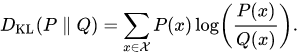

* *Jensen–Shannon divergence* - It is based on the Kullback–Leibler divergence, with some notable (and useful) differences, including that it is symmetric and it always has a finite value. The square root of the Jensen–Shannon divergence is a metric often referred to as Jensen-Shannon distance.


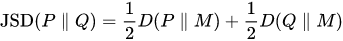

where 


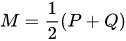

In [12]:
df1 = pd.DataFrame(columns = ['parameters','wasserstein', 'KL', 'JS']) 
df1["parameters"] = mtrics.keys()
df1[['wasserstein', 'KL', 'JS']] = list(mtrics.values())

In [13]:
df1

,parameters,wasserstein,KL,JS
0,-0.01:-0.99,2.916667,15.704567,0.249397
1,-0.0325:-0.9675,1.675000,40.264554,0.390679
2,-0.05500000000000001:-0.945,1.591667,54.583444,0.464846
3,-0.0775:-0.9225,1.966667,58.348927,0.483208
4,-0.1:-0.9,1.358333,59.707333,0.482626


In [18]:
kpis['-0.1:-0.9']

,name,REVENUE,nRIDES,fare
0,174977a1-d03c-4e8c-b622-059463bc73cc,743.709184,9.700000,7.680
1,1f46083c-70ac-4601-9c99-3f4afeb79c06,306.566667,0.566667,5.410
2,322ad7b9-f077-4036-91ec-8d096d3e861a,698.886965,1.433333,27.510
3,8f27bd23-732f-4239-9bcd-7da58223de64,993.558832,11.233333,10.740
4,943f9979-e5ca-49cf-953b-194fa1f49717,851.929431,16.133333,8.565
5,acca2209-3036-4697-a101-8e1da46ae908,368.200000,0.700000,5.260
6,b7f9fa8d-c735-49d2-acb6-470980003c3f,1023.753842,14.300000,9.950
7,ed6a7d77-619e-4249-a02b-9046616ca94c,368.915623,0.933333,6.700


In [15]:
real_kpis = df[df['quotes_list_id_flag'] == 1][["fleet_id", "price_high_value"]].groupby("fleet_id").agg({"price_high_value": ["sum", "count"] }).reset_index()
real_kpis.columns = ["_".join(a) for a in real_kpis.columns.to_flat_index()]
real_kpis = real_kpis.rename(columns={"fleet_id_":"name", "price_high_value_count": "number_of_rides_real", "price_high_value_sum": "revenue_real"})
real_kpis

,name,revenue_real,number_of_rides_real
0,174977a1-d03c-4e8c-b622-059463bc73cc,156.24,7
1,1f46083c-70ac-4601-9c99-3f4afeb79c06,221.90,10
2,322ad7b9-f077-4036-91ec-8d096d3e861a,59.99,1
3,8f27bd23-732f-4239-9bcd-7da58223de64,8.75,1
4,943f9979-e5ca-49cf-953b-194fa1f49717,45.75,2
5,acca2209-3036-4697-a101-8e1da46ae908,39.38,3
6,b7f9fa8d-c735-49d2-acb6-470980003c3f,308.10,17
7,ed6a7d77-619e-4249-a02b-9046616ca94c,334.78,17


## Data save

In [21]:
import json

dict_to_save = {}
index = 0
for value in vehicles_seedings:
    dict_to_save[index] = value.to_json(orient="records")
    index += 1

# dict_to_save
json = json.dumps(dict(dict_to_save))

f = open("30-days-dict-vehicle-seeding-2.json","w")
f.write(json)
f.close()

In [23]:
df1.to_csv("30-days-2.csv")

In [22]:
import json

dict_to_save = {}
for i, v in kpis.items():
    dict_to_save[i] = v.to_json(orient="records")

json = json.dumps(dict_to_save)

f = open("30-days-dict-2.json","w")
f.write(json)
f.close()